In [2]:
import numpy as np
import pwlreg as pw
import matplotlib.pyplot as plt

# pwlreg Quick Start

In [3]:
x = np.array([1., 2., 3., 4., 5., 6., 7., 8., 9., 10.])
y = np.array([1., 1.5, 0.5, 1., 1.25, 2.75, 4, 5.25, 6., 8.5])

In [4]:
m = pw.AutoPiecewiseRegression(n_segments=2, degree=[0, 1])
m.fit(x, y)

AutoPiecewiseRegression(degree=[0, 1], n_segments=2)

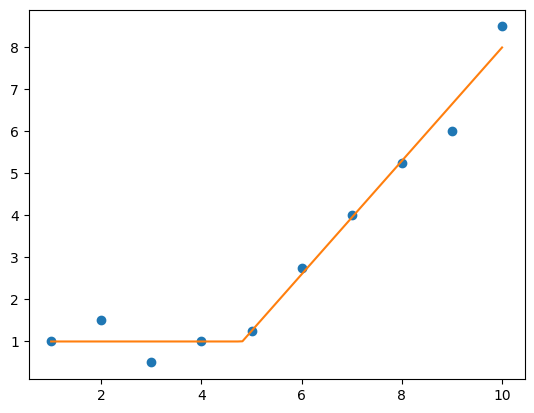

In [5]:
xx = np.linspace(1, 10, 100)
plt.plot(x, y, "o")
plt.plot(xx, m.predict(xx), "-")
plt.show()

In [6]:
m.breakpoints_

array([ 1.        ,  4.81481476, 10.        ])

# How to Use pwlreg

`pwlreg` performs __p__ iece __w__ ise __l__ inear __reg__ ression. It is general enough to suit any use case, but it was developed specifically to estimate change-point building energy models. ASHRAE calls this family of models "inverse models"; they are really just regression models with two or three piecewise components.

The `pwlreg` library was written to be fully compatible with the [scikit-learn](https://scikit-learn.org/dev/index.html) API. It exposes two estimators: `PiecewiseLinearRegression` and `AutoPiecewiseRegression`. They differ in how they handle breakpoints (or change points): if you want to specify the breakpoints yourself, use `PiecewiseLinearRegression`. If you want to find the optimal breakpoints automatically, use `AutoPiecewiseRegression`.

## Piecewise regression with fixed breakpoints

There are two primary arguments to the `PiecewiseLinearRegression` constructor: the breakpoint locations and the degree(s) of the fitted polynomial(s). Using the defaults results in a model that is identical to if you had used ordinary linear regression:

In [7]:
m1 = pw.PiecewiseLinearRegression()
m1.fit(x, y)

PiecewiseLinearRegression(breakpoints=array([ 1., 10.]), degree=[1])

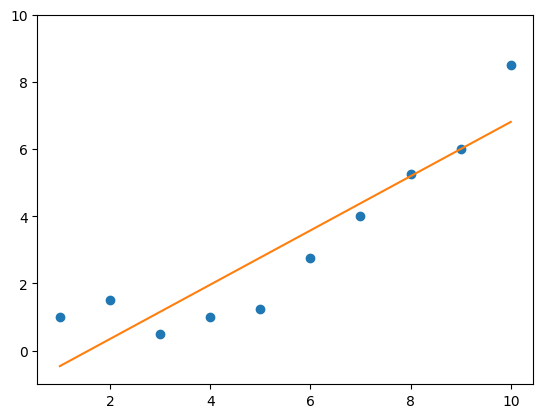

In [27]:
plt.plot(x, y, "o")
plt.plot(xx, m1.predict(xx), "-")
plt.ylim(-1, 10)
plt.show()

You can view the breakpoints and the model coefficients once the model has been fit.

In [9]:
print("Breakpoints:", m1.breakpoints)
print("Coefs:", m1.coef_)

Breakpoints: [ 1. 10.]
Coefs: [-1.26666667  0.80757576]


And you can calculate model metrics however you are accustomed to:

In [13]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y, m1.predict(x), squared=False)
print("RMSE:", rmse)
print("CVRMSE: {:.2%}".format(rmse / y.mean()))

RMSE: 1.0405054133215816
CVRMSE: 32.77%


To specify a breakpoint, the `breakpoints` argument must include the minimum and maximum values of the input data. Notice that when we passed `breakpoints=None` above, the estimator automatically set the breakpoints to 1 and 10. If you pass the breakpoints manually, you will need to explicitly provide these. For example, suppose we wanted to put a breakpoint at `x = 4`.

In [22]:
m2 = pw.PiecewiseLinearRegression(breakpoints=[1., 4., 10.])
m2.fit(x, y)

PiecewiseLinearRegression(breakpoints=[1.0, 4.0, 10.0], degree=[1, 1])

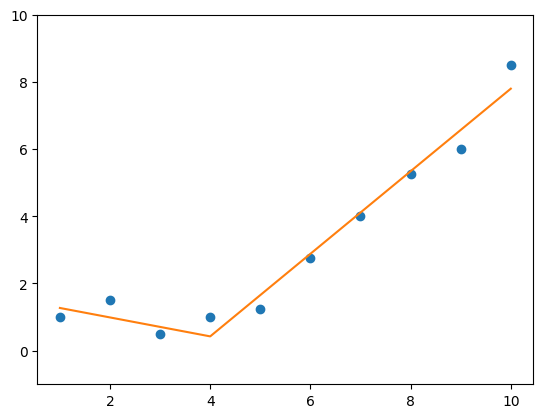

In [28]:
plt.plot(x, y, "o")
plt.plot(xx, m2.predict(xx), "-")
plt.ylim(-1, 10)
plt.show()

Now there are four model coefficients. In order, these are: the intercept and slope of the first (leftmost) line segment, and the intercept and slope of the last line segment.

In [30]:
m2.coef_

array([ 1.55319149, -0.28191489, -4.4893617 ,  1.2287234 ])

The model fits significantly better than the single line did, as we can see both visually and with error metrics:

In [31]:
rmse = mean_squared_error(y, m2.predict(x), squared=False)
print("RMSE:", rmse)
print("CVRMSE: {:.2%}".format(rmse / y.mean()))

RMSE: 0.4154592434628495
CVRMSE: 13.09%


By default, each segment is a 1-degree polynomial (i.e. a line). In some change-point models, we want to restrict one or more segments to be constant. Do that by passing the `degree` argument as a list, with one degree value for each line segment.

In [34]:
m3 = pw.PiecewiseLinearRegression(breakpoints=[1., 3.5, 10.], degree=[0, 1])
m3.fit(x, y)

PiecewiseLinearRegression(breakpoints=[1.0, 3.5, 10.0], degree=[0, 1])

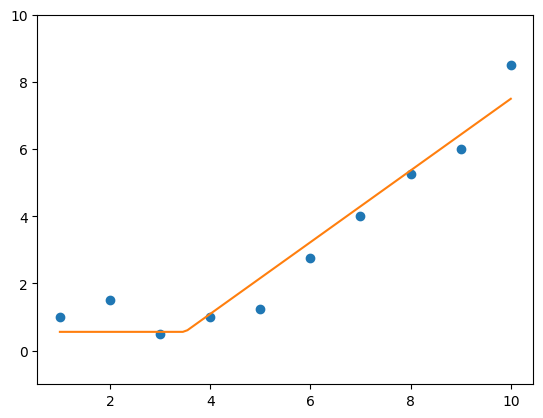

In [36]:
plt.plot(x, y, "o")
plt.plot(xx, m3.predict(xx), "-")
plt.ylim(-1, 10)
plt.show()

Now there are only three model coefficients. Because the first segment is a flat line, it only has one coefficient, the constant term. The second and third coefficients are the intercept and slope of the last segment as before.

In [37]:
m3.coef_

array([ 0.56026059, -3.17508143,  1.06724058])

This model fits better than the single line did, but not as well as the one with two degree-one segments. Maybe we picked the wrong breakpoint?

In [39]:
rmse = mean_squared_error(y, m3.predict(x), squared=False)
print("RMSE:", rmse)
print("CVRMSE: {:.2%}".format(rmse / y.mean()))

RMSE: 0.5863738922856399
CVRMSE: 18.47%


## Piecewise regression with unknown breakpoints

To use `AutoPiecewiseRegression`, specify the number of line segments rather than the locations of the breakpoints. You can specify the degrees in the same way as with `PiecewiseLinearRegression`.

In [40]:
m4 = pw.AutoPiecewiseRegression(n_segments=2, degree=[0, 1])
m4.fit(x, y)

AutoPiecewiseRegression(degree=[0, 1], n_segments=2)

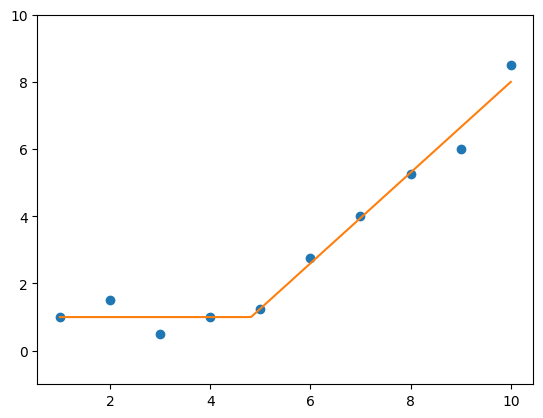

In [41]:
plt.plot(x, y, "o")
plt.plot(xx, m4.predict(xx), "-")
plt.ylim(-1, 10)
plt.show()

This looks like a better location for the breakpoint. We can once again inspect the breakpoint, the model coefficients, and the error metrics:

In [45]:
print("Breakpoints:", m4.breakpoints_)
print("Coefficients:", m4.coef_)

rmse = mean_squared_error(y, m4.predict(x), squared=False)
print("RMSE:", rmse)
print("CVRMSE: {:.2%}".format(rmse / y.mean()))

Breakpoints: [ 1.          4.81481477 10.        ]
Coefficients: [ 0.99999998 -5.49999991  1.34999999]
RMSE: 0.34641016151377585
CVRMSE: 10.91%


This is our best-fitting model yet. The optimal breakpoint is around 4.8. We are not limited to straight lines if we think a quadratic might give us a better fit:

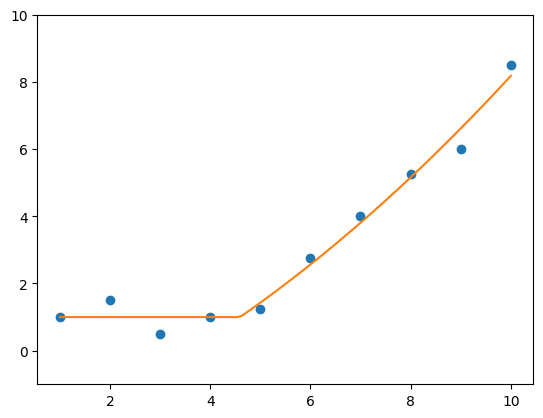

In [46]:
m5 = pw.AutoPiecewiseRegression(2, degree=[0, 2])
m5.fit(x, y)

plt.plot(x, y, "o")
plt.plot(xx, m5.predict(xx), "-")
plt.ylim(-1, 10)
plt.show()

In [47]:
rmse = mean_squared_error(y, m5.predict(x), squared=False)
print("RMSE:", rmse)
print("CVRMSE: {:.2%}".format(rmse / y.mean()))

RMSE: 0.3305838990117023
CVRMSE: 10.41%


## Advanced Use

Because `pwlreg` is compatible with scikit-learn, it can be used in the latter's pipelines, transformations, and cross-validation techniques. Suppose we weren't sure which kind of change-point model to use for a certain dataset, and we wanted a data-driven approach to selecting the best-performing one.

We'll first simulate a larger realistic-ish dataset.

In [62]:
rng = np.random.default_rng(1234)
cp1, cp2 = 52, 73

x = np.concatenate(
    (
        rng.uniform(0, cp1, 300),
        rng.uniform(cp1, cp2, 400),
        rng.uniform(cp2, 100, 300),
    )
)

y = np.piecewise(
    x,
    [x < cp1, (cp1 <= x) & (x < cp2), x >= cp2],
    [
        lambda a: 10 + 0.25 * (cp1 - a),
        10,
        lambda a: 10 + 0.5 * (a - cp2),
    ]
)

sigma = np.piecewise(
    x,
    [x < cp1, (cp1 <= x) & (x < cp2), x >= cp2],
    [
        lambda a: 1 + 0.10 * (cp1 - a),
        1,
        lambda a: 1 + 0.15 * (a - cp2),
    ]
)

y += rng.normal(0, sigma, 1000)
y = np.abs(y)

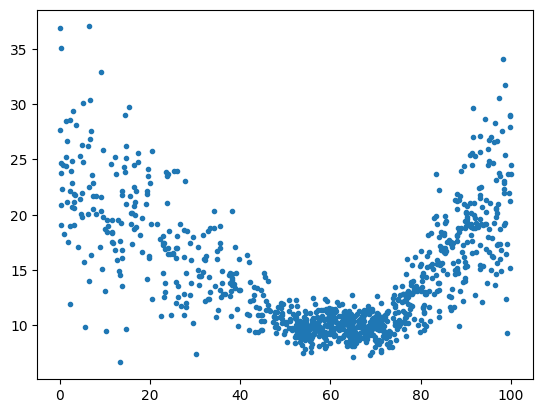

In [64]:
plt.plot(x, y, ".")
plt.show()

### Cross Validation

In [81]:
from sklearn.model_selection import GridSearchCV

m = pw.AutoPiecewiseRegression(n_segments=1)
params = [
    {
        "n_segments": [1],
        "degree": [0, 1, 2],
    },
    {
        "n_segments": [2],
        "degree": [[0, 0], [0, 1], [1, 0], [1, 1]],
    },
    {
        "n_segments": [3],
        "degree": [
            [0, 0, 0],
            [0, 0, 1],
            [0, 1, 0],
            [0, 1, 1],
            [1, 0, 0],
            [1, 0, 1],
            [1, 1, 0],
            [1, 1, 1],
        ],
    },
]
cv = GridSearchCV(
    m,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    scoring="neg_root_mean_squared_error",
    verbose=2
)
cv.fit(x, y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5, estimator=AutoPiecewiseRegression(n_segments=1), n_jobs=-1,
             param_grid=[{'degree': [0, 1, 2], 'n_segments': [1]},
                         {'degree': [[0, 0], [0, 1], [1, 0], [1, 1]],
                          'n_segments': [2]},
                         {'degree': [[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1],
                                     [1, 0, 0], [1, 0, 1], [1, 1, 0],
                                     [1, 1, 1]],
                          'n_segments': [3]}],
             scoring='neg_root_mean_squared_error', verbose=2)

In [82]:
results = cv.cv_results_

In [93]:
for i in range(4):
    for candidate in np.flatnonzero(results["rank_test_score"] == i):
        print("Model {0}".format(i))
        print(
                "Mean RMSE: {0:.3f} (std: {1:.3f})".format(
                    -1. * results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
        )
        print("Parameters: {0}".format(results["params"][candidate]))
        print("")

Model 1
Mean RMSE: 3.027 (std: 1.140)
Parameters: {'degree': [1, 0, 1], 'n_segments': 3}

Model 2
Mean RMSE: 3.028 (std: 1.140)
Parameters: {'degree': [1, 1, 1], 'n_segments': 3}

Model 3
Mean RMSE: 3.170 (std: 0.980)
Parameters: {'degree': [0, 1, 1], 'n_segments': 3}



In [89]:
m_best = cv.best_estimator_

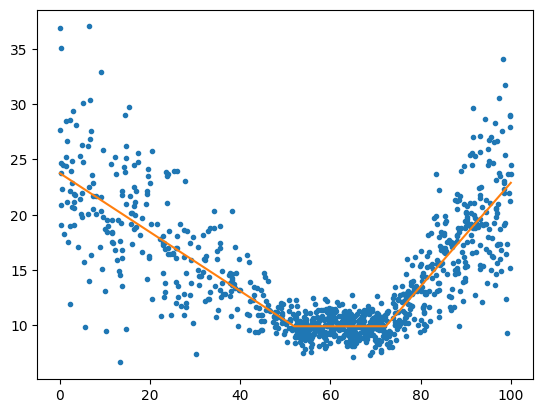

In [92]:
xx = np.linspace(x.min(), x.max(), 1000)
plt.plot(x, y, ".")
plt.plot(xx, m_best.predict(xx), "-")
plt.show()

In [97]:
m_best.breakpoints_

array([2.39868656e-03, 5.19420533e+01, 7.22632131e+01, 9.99766492e+01])

In [94]:
rmse = mean_squared_error(y, m_best.predict(x), squared=False)
print("RMSE:", rmse)
print("CVRMSE: {:.2%}".format(rmse / y.mean()))

RMSE: 2.8826583907605454
CVRMSE: 20.46%


### Continuity

If you don't want to enforce continuity of the line segments for some reason, just pass `continuity=None` to either estimator.

In [102]:
m6 = pw.AutoPiecewiseRegression(n_segments=3, degree=1, continuity=None)
m6.fit(x, y)

AutoPiecewiseRegression(continuity=None, degree=[1, 1, 1], n_segments=3)

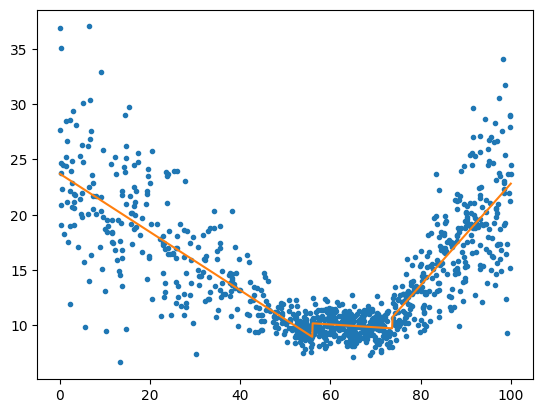

In [103]:
plt.plot(x, y, ".")
plt.plot(xx, m6.predict(xx), "-")
plt.show()

In [104]:
rmse = mean_squared_error(y, m6.predict(x), squared=False)
print("RMSE:", rmse)
print("CVRMSE: {:.2%}".format(rmse / y.mean()))

RMSE: 2.8786752149931076
CVRMSE: 20.43%


### Sample weights

Weighted regression is supported by passing `weights` to the `.fit()` method. This makes little difference in this contrived example, but it could help the fit in areas of the data that are more important than others.

In [105]:
m7 = pw.AutoPiecewiseRegression(n_segments=3, degree=[1, 0, 1])
m7.fit(x, y, weights=1/sigma)

AutoPiecewiseRegression(degree=[1, 0, 1], n_segments=3)

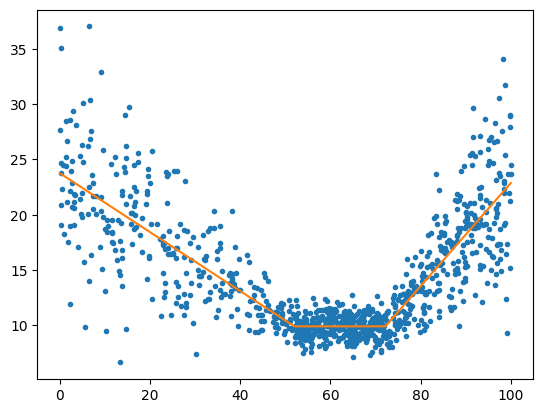

In [106]:
plt.plot(x, y, ".")
plt.plot(xx, m7.predict(xx), "-")
plt.show()

In [100]:
m7.breakpoints_

array([2.39868656e-03, 5.19644565e+01, 7.21748509e+01, 9.99766492e+01])

In [107]:
rmse = mean_squared_error(y, m7.predict(x), squared=False)
print("RMSE:", rmse)
print("CVRMSE: {:.2%}".format(rmse / y.mean()))

RMSE: 2.8826775975759773
CVRMSE: 20.46%


## Future enhancements

* Standard errors and p-values for coefficients
* C2 continuity (continuity of the line segments and their derivatives)